In the first part we took a deep dive into the data and trends of shots based on three key variables. We developed an understanding of the distributions and probabilities associated with shots and goals, by representing, transforming and visualizing the data. A natural progression would now be to develop a model that takes in our three predictors (distance, angle and binary descriptor for a header) and returns a probability of a shot resulting in a goal. 


We are going to import our shot_matrix function from part 1 and use to recreate our data frame. 

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Importing Jupyter notebook from xG_model_part1.ipynb


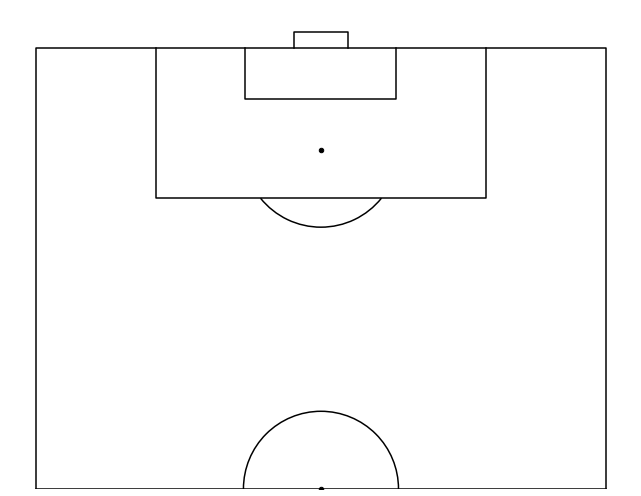

xG_model_part1.ipynb:49: RuntimeWarning: invalid value encountered in arccos
  "source": [


In [2]:
#for extended notes and descriptions, visit part 1
#use nbimporter to extract our shot_matrix function from part 1
import nbimporter
from xG_model_part1 import shot_matrix
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from PlotPitch import draw_pitch
directory = '/Users/Ian/Desktop/IDanalytics/event_data'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

In [3]:
df = df.dropna()
#df = df.drop(columns = ['x','y','Center_dis'])
df['header'] = pd.to_numeric(df['header'])
df['Goal'] = pd.to_numeric(df['Goal'])
df

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
213,1,6,57,256992,3799,2500686,0,38.76,6.30,7.0,7.896050,0.755576,43.291300
302,0,17,42,334552,3772,2500686,1,28.56,17.85,8.0,18.660549,0.372069,21.317963
498,1,4,43,26389,3772,2500686,0,29.24,4.20,7.0,6.348039,0.851948,48.813019
577,0,16,21,276920,3772,2500686,0,14.28,16.80,29.0,25.905953,0.184838,10.590449
629,0,27,51,366760,3799,2500686,0,34.68,28.35,1.0,28.358154,0.256637,14.704224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528


Since our response variable (shot result) is categorical, we must apply appoaches that are know as classification. To introuce classification, let's look at an example. Assume we plot a random selection of shots from our data and classify them based on their result. For now we are going to focus on the distance predictor. 

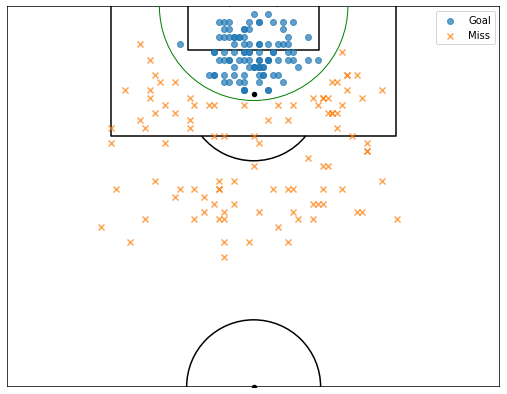

In [4]:
from PlotPitch import draw_pitch
idx_goal = np.where((df['Goal']==1) & (df['Distance'] < 12)) 
df_HS_goal = df.iloc[idx_goal]
idx_miss = np.where((df['Goal']==0) & (df['Distance']> 13)) 
df_HS_miss = df.iloc[idx_miss]


#probabilty of shot resulting in goals based on 
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_HS_goal.head(100),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_HS_miss.head(100),x='Y', y='X',alpha=.7,marker='x')
ax.set_xlim(0,68)
plt.legend((goals,misses),('Goal','Miss'))
ax.set_ylim(52.5,0)
circle = plt.Circle((34,0),13,fill=False, color = 'Green')
ax.add_artist(circle)
plt.axis('off')

plt.show()


Now this is quite an assumption but let's stick with it for demonstration. Above we can see that there is a clear distinction between the two clusters, in blue and orange. The question is, if we want to predict future shots results based on the data above, how could we classify them. 

Since the data is easily seperable, we can create a boundary line, also know as a discriminant function, that will classify each response (0 or 1 for the result of a shot) based on the distance predictor variable. In the case above, this is a function that maps out a distance r from the center of the goal. The function, drawn in green, is defined by the equation $ y = \alpha x +\beta$, where x is the distance from goal and y in the binary response.  Specifically for the data above y = x -12. We can translate this into a classification model by applying the heaviside function to our discriminant, which returns a 0 or 1 response variable based on the value of y. 

$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      0 & \mathrm{if}\ y > 0
      \\
      1 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$



The Heaviside function is a sharp boundary line, assigning hard 0 or 1s based on which side of the boundary the data point is on. This is the simpliest classification model but it requires the data to be cleanly seperable. 

Text(0.5, 1.0, 'Heaviside Function Classification for Shots')

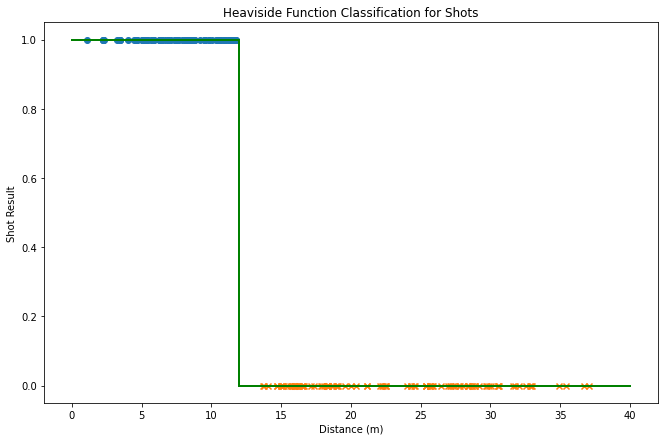

In [5]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))

goals = plt.scatter(df_HS_goal['Distance'].head(100),df_HS_goal['Goal'].head(100))
misses = plt.scatter(df_HS_miss['Distance'].head(100),df_HS_miss['Goal'].head(100),marker='x')
plt.plot([0,12], [1, 1], 'k-', lw=2,c='green')
plt.plot([12,12], [0, 1], 'k-', lw=2,c='green')
plt.plot([12,40], [0, 0], 'k-', lw=2,c='green')
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.title('Heaviside Function Classification for Shots')


    

As we know, the data describing shots is not cleanly seperable, so the heaviside function is not useful when looking a more complex data. Alas, it serves as a natural progression into more advanced classification models. If we took a sample of our data, it might resemble the plot below. 

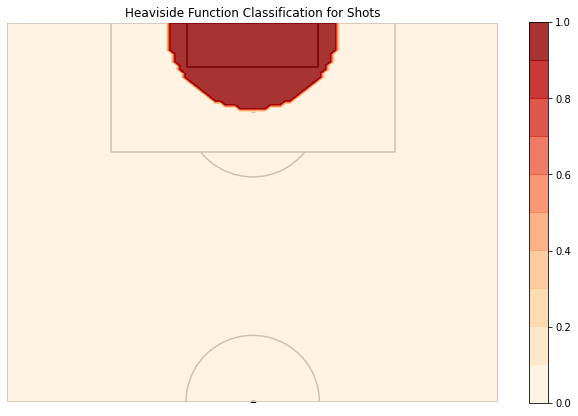

In [10]:
#we are going to create a contour plot to see how the heaviside function classifies
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from PlotPitch import draw_pitch 
def heaviside(Y):
    A = np.where(Y<=0, 0, 1)
    return A

def heaviside_int(x1):
    'computes heaviside step function'
    return heaviside(x1).astype(dtype = int)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)

x0 = np.linspace(0, 68, 100)
x1 = np.linspace(0,53 , 100)
x11 = np.linspace(53,0 , 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
h_grid = heaviside_int(144-(x0_grid-34)**2-(x1_grid-53)**2)
plt.contourf(x0, x11, h_grid,cmap='OrRd',alpha=.8,levels=10)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Heaviside Function Classification for Shots')

plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()

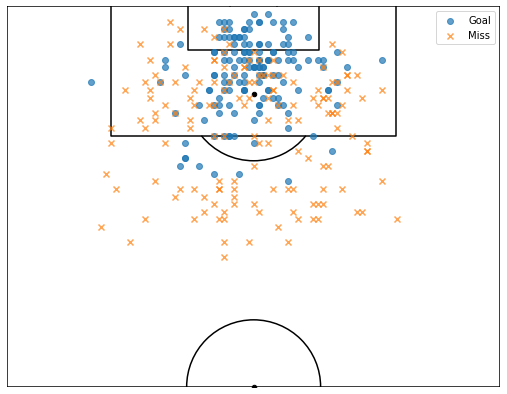

In [11]:
idx = np.where((df['Goal']==1) & (df['Distance'] < 25)) 
df_log_goal = df.iloc[idx]
idx = np.where((df['Goal']==0) & (df['Distance']> 5)) 
df_log_miss = df.iloc[idx]


#probabilty of shot resulting in goals based on 
prob=np.array(df['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_log_goal.head(150),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_log_miss.head(150),x='Y', y='X',alpha=.7,marker='x')
classifer = Arc(xy=(10,10),width=12,height=12)
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.legend((goals,misses),('Goal','Miss'))
plt.axis('off')


plt.show()

In the event where the data is not cleanly seperable we must adopt a different technique. 


$$
\begin{array}{rcl}
  G(y) & \equiv & \dfrac{1}{1 + e^{-y}} \equiv \dfrac{1}{1+e^{-(\alpha x_{1} +\beta x_{2}+\gamma x_{3} +\delta)}}
\end{array}
$$



The logistic function takes any value in the domain $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $y$, we can interpret $G(y)$ as a conditional probability that the shot results in a goal, $G(y) \equiv \mathrm{Pr}[\mbox{label is }1 \,|\, y]$.

[ 8 -1  1  6  9 -1  8 -2  8  5  7  8  7  0  5  6 -1  5 -1  8  6  4  2  3
  7 -1 -1  5 -1  1  2  7  3  3  1  5  1  8 -1  1]


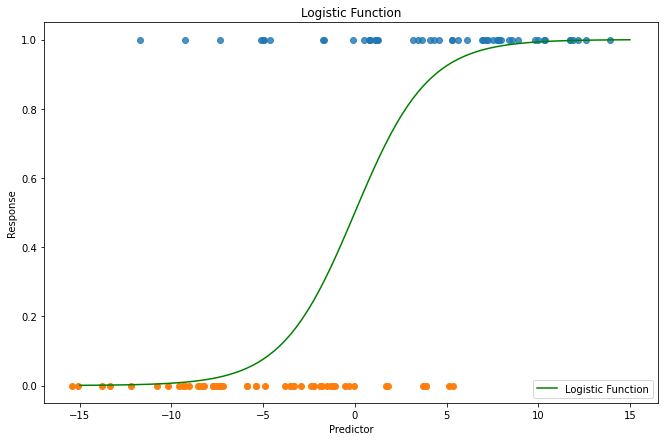

In [112]:

fig, ax = plt.subplots(figsize=(11, 7))
#ones = np.array[]
plt.scatter(np.random.normal(5,5,50),np.random.randint(1,2,50),alpha=.8)
plt.scatter(np.random.normal(-5,5,50),np.random.randint(0,1,50))

y = np.linspace(-15,15,100)
plt.plot(y,1/(1+np.exp(-(.5*y))),c='Green',label='Logistic Function')

plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Logistic Function')
plt.legend()
print(np.random.randint(-2,10, size=40))


$$
\begin{array}{rcl}
  Log \space Odds & \equiv & \dfrac{Probability}{1 - Probability} 
\end{array}
$$


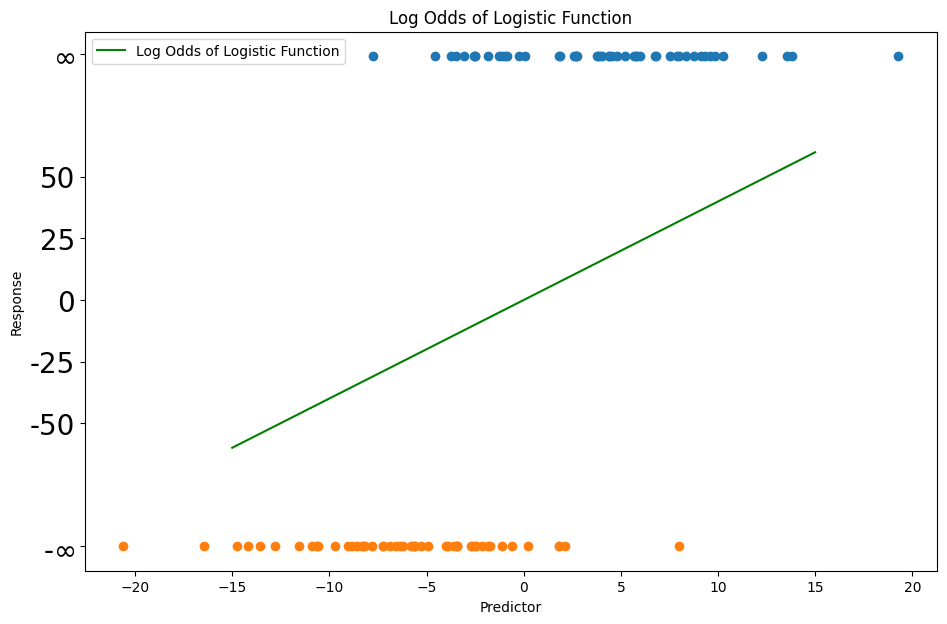

In [186]:
fig, ax = plt.subplots(figsize=(11, 7))
#ones = np.array[]
plt.scatter(np.random.normal(5,5,50),np.random.randint(99,100,50))
plt.scatter(np.random.normal(-5,5,50),np.random.randint(-100,-99,50))


y = np.linspace(-15,15,100)
plt.plot(y,4*y,c='Green',label='Log Odds of Logistic Function')

y = np.array([-100,-50,-25,0,25,50,100])
my_xticks = ["-$\infty$",'-50','-25','0','25','50',"$\infty$"]
plt.yticks(y, my_xticks,fontsize=20)

plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Log Odds of Logistic Function')
plt.legend()




In [13]:


#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor
from sklearn import metrics 
from sklearn.model_selection import train_test_split
train_dis = df[['Goal','Distance']].copy()
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.14641592]] [0.09763449]


,coef
Distance,-0.146416


$$
\begin{array}{rcl}
  G(y) =  \dfrac{1}{1+e^{(0.146*distance - 0.097)}}
\end{array}
$$

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

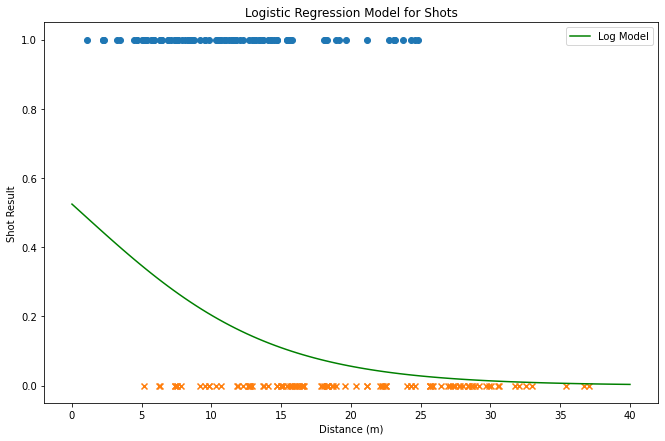

In [14]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_log_goal['Distance'].head(100), df_log_miss['Distance'].head(100))
df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))
goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(0,40,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='Green',label='Log Model')

plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')


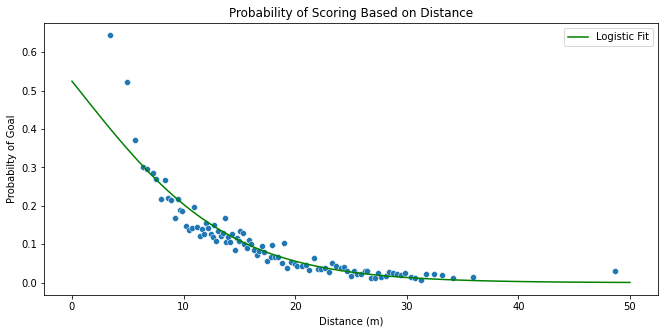

In [15]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.146*dis-.097))),color='green',legend='auto',label='Logistic Fit')


plt.show()

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
df_dis_2 = df[['Goal','Distance']].copy()
x_train_dis_2, x_test_dis_2, y_train_dis_2, y_test_dis_2 = train_test_split(df_dis_2.drop('Goal',axis=1), 
                                                    df_dis_2['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lgm_dis_2 = LogisticRegression()
lgm_dis_2.fit(x_train_dis_2,y_train_dis_2)
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lgm_dis_2)])
pipe.fit(x_train_dis_2, y_train_dis_2)



print(lgm_dis_2.coef_,lgm_dis_2.intercept_)

[[-0.21632621  0.00206089]] [0.58419379]


$$
\begin{array}{rcl}
  G(y) =  \dfrac{1}{1+e^{(0.216*distance - 0.002*distance^2 - 0.584)}}
\end{array}
$$

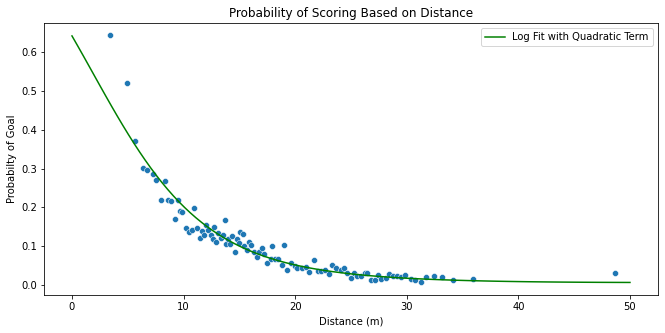

In [21]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.21632621*dis-0.00206089*dis**2-0.58419379))),color='green',
             label='Log Fit with Quadratic Term')



plt.show()

In [22]:
#we are going to split the data into a test and train set(20% of it will go towards testing)
#for now we are going to model just the distance predictor

train_ang = df[['Goal','Angle Degrees']].copy()
x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
                                                    train_ang['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_ang = LogisticRegression()
lgm_ang.fit(x_train_ang,y_train_ang)
log_odds_ang = lgm_ang.coef_[0]
print(lgm_ang.coef_, lgm_ang.intercept_)
pd.DataFrame(log_odds_ang, 
             x_train_ang.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[0.05221106]] [-3.60645775]


,coef
Angle Degrees,0.052211


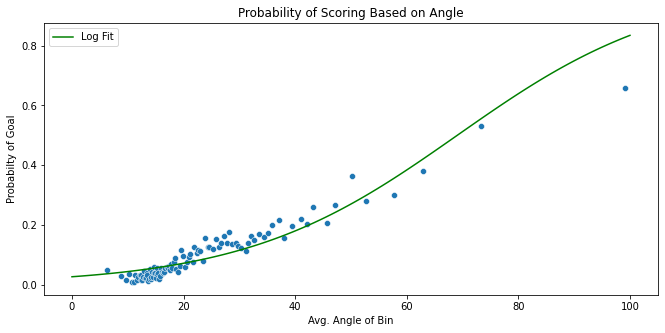

In [23]:
#same for the angle
fig, axes = plt.subplots(figsize=(11, 5))
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=100)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
ang = np.linspace(0,100,100)
sns.lineplot(x = ang,y = 1/(1+np.exp(-(lgm_ang.coef_[0][0]*ang+lgm_ang.intercept_[0]))),color='green',
             label='Log Fit')


plt.show()

In [25]:
df_poly_ang = df[['Goal','Angle Degrees']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(df_poly_ang.drop('Goal',axis=1), 
                                                    df_poly_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lr_ang_poly = LogisticRegression()
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr_ang_poly)])
pipe.fit(X_train, Y_train)

log_odds = lr_ang_poly.coef_[0]


print(lr_ang_poly.coef_,lr_ang_poly.intercept_)

[[ 0.08400573 -0.00035088]] [-4.14642689]


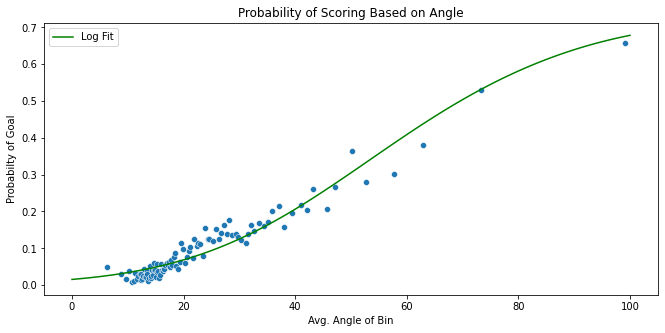

In [26]:
#same for the angle
fig, axes = plt.subplots(figsize=(11, 5))
df['Angle_Bins'] = pd.qcut(df['Angle Degrees'],q=100)
angle_prob = df.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
ang = np.linspace(0,100,100)
sns.lineplot(x = ang,y = 1/(1+np.exp(-(lr_ang_poly.coef_[0][0]*ang + lr_ang_poly.coef_[0][1]*ang**2
                                       + lr_ang_poly.intercept_[0]))),color='green',
             label='Log Fit')


plt.show()

In [27]:
train_2 = df[['Goal','Distance','Angle Radians']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                    train_2['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_2 = LogisticRegression(random_state=0)
lgm_2.fit(x_train_2,y_train_2)
log_odds = lgm_2.coef_[0]
print(lgm_2.coef_, lgm_2.intercept_)
print(pd.DataFrame(log_odds, 
             x_train_2.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))
lgm_2.coef_[0][1]

[[-0.08801449  1.41598327]] [-1.48107418]
                   coef
Angle Radians  1.415983
Distance      -0.088014


1.4159832678520228

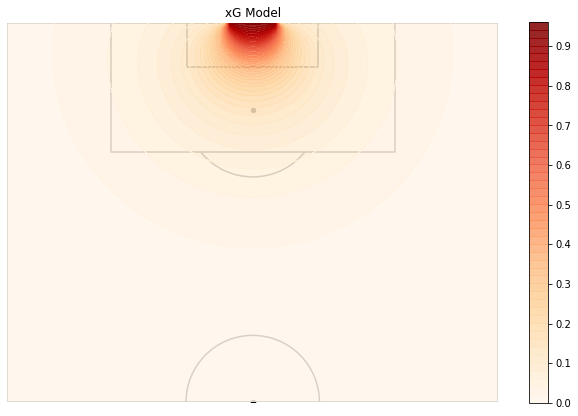

In [128]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(lgm_2.coef_[0][1]*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  +lgm_2.coef_[0][0]*np.sqrt((x1_grid)**2+(x0_grid)**2)+lgm_2.intercept_[0])


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid,alpha=.85,cmap='OrRd',levels=50)


plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()


(22.0, 0.0)

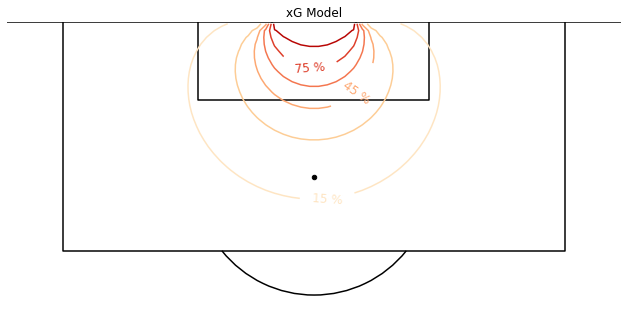

In [29]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(1.57148079*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  -0.11023242*np.sqrt((x1_grid)**2+(x0_grid)**2)-1.02645936)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contour(x_0,x1, h_grid,alpha=1,cmap='OrRd',levels=7)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[1::2],inline=True, fmt=fmt, fontsize=12)

plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)



In [30]:
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
df_3 = df[['Goal','Distance','Angle Radians','Y']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_3.drop('Goal',axis=1), 
                                                    df_3['Goal'], test_size=0.20, 
                                                    random_state=10)
#ct = ColumnTransformer([('poly_X0X1', PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False), 
#                         ['Distance','Angle Radians']),
#                         ('poly_x0**2', FunctionTransformer(func=lambda x: x**2), ['Distance']),
#                         ('Y',FunctionTransformer(func=lambda x: x),['Y'])])

#poly_train = ct.fit_transform(X_train)
#poly_test = ct.fit_transform(X_test)


lgm_3 = LogisticRegression()

lgm_3.fit(x_train_3, y_train_3)
#print('dis, ang, Y')
print(lgm_3.coef_,lgm_3.intercept_)


[[-0.08812064  1.41583297 -0.00209564]] [-1.40900091]


(27.0, 0.0)

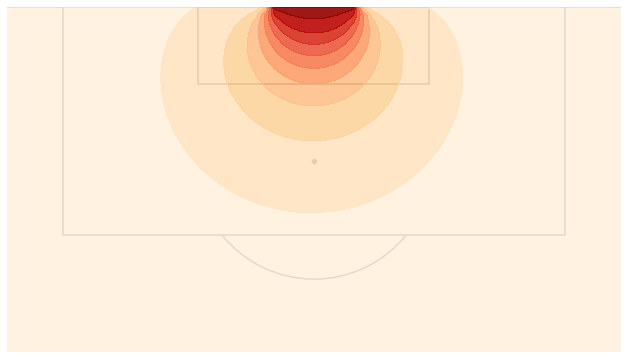

In [31]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)

x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
ang = np.arccos((c**2-a**2-b**2)/(-2*a*b))
dis = np.sqrt((x1_grid)**2+(x0_grid)**2)
#h_grid_poly = Logistic(lr.coef_[0][0]*dis +lr.coef_[0][1]*ang + lr.coef_[0][2]*dis*ang +
#                       lr.coef_[0][3]*(ang**2)+lr.coef_[0][3]*x0_grid+lr.intercept_[0])

h_grid_Y = Logistic(lgm_3.coef_[0][0]*dis +lgm_3.coef_[0][1]*ang +lgm_3.coef_[0][2]*(x0_grid) +lgm_3.intercept_[0])



fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid_Y,alpha=.9,cmap='OrRd',levels=10)


#plt.title('xG Model')

plt.axis('off')

ax.set_xlim(10,58)
ax.set_ylim(27,0)
#ax.set_xlim(0,68)
#ax.set_ylim(53,0)
#plt.colorbar()


(22.0, 0.0)

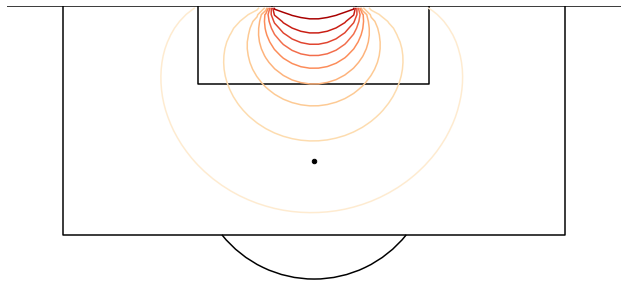

In [32]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)



CS =plt.contour(x_0,x1, h_grid_Y,alpha=1,cmap='OrRd',levels=10)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
#plt.clabel(CS, CS.levels[:3],inline=True, fmt=fmt, fontsize=10)

#plt.title('xG Model (with added distance to center variable)')

#plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)

# Model Evaluation

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

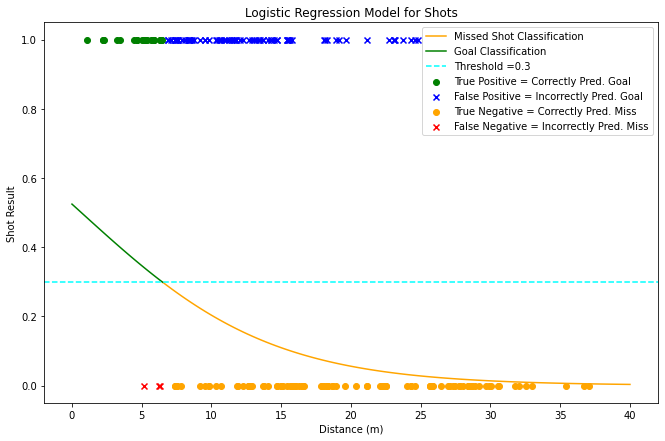

In [81]:
#plot the heaviside function on top of the responses for the seperable data above
threshold=0.3
threshold_x=6.5
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')


[[7022  186]
 [ 711  173]]


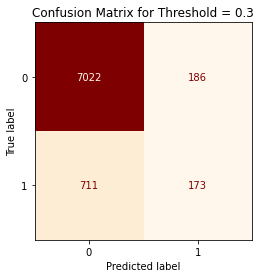

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
threshold=[0.3]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_3 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_3).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.3')
print(cm_dis_3)

In [35]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_3 = cm_dis_3[1][1]/(cm_dis_3[1][1]+cm_dis_3[1][0])
print('sensitivity = ' + str(sensitivity_3))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_3 = cm_dis_3[0][0]/(cm_dis_3[0][1]+cm_dis_3[0][0])
print('specificity = '+ str(specificity_3) )

sensitivity = 0.19570135746606335
specificity = 0.9741953385127636


Text(0.5, 1.0, 'Logistic Regression Model for Shots')

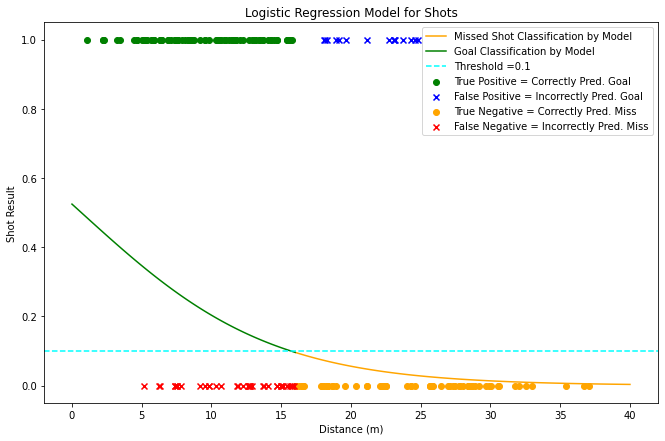

In [82]:

threshold=0.1
threshold_x=16
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification by Model')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification by Model')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')



[[4400 2808]
 [ 196  688]]


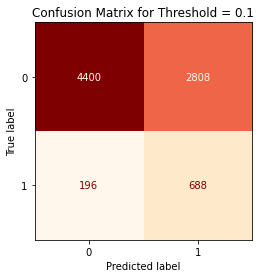

In [38]:
threshold=[0.1]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_10 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_10).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.1')
print(cm_dis_10)

In [40]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_10 = cm_dis_10[1][1]/(cm_dis_10[1][1]+cm_dis_10[1][0])
print('sensitivity = ' + str(sensitivity_10))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_10 = cm_dis_10[0][0]/(cm_dis_10[0][0]+cm_dis_10[0][1])
print('specificity = '+ str(specificity_10) )
print(cm_dis_10[0][1])

sensitivity = 0.7782805429864253
specificity = 0.6104328523862376
2808


Text(0.5, 1.0, 'Logistic Regression Model for Shots')

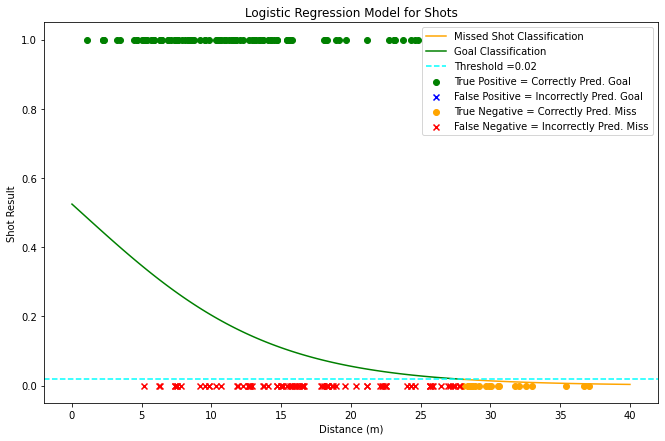

In [83]:

threshold=0.02
threshold_x=28
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')




[[1372 5836]
 [  29  855]]


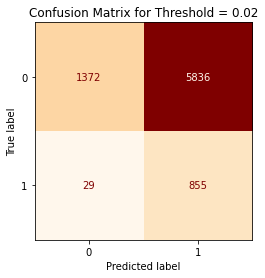

In [44]:
threshold=[0.02]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_02 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_02).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.02')
print(cm_dis_02)

In [46]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_02 = cm_dis_02[1][1]/(cm_dis_02[1][1]+cm_dis_02[1][0])
print('sensitivity = ' + str(sensitivity_02))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_02 = cm_dis_02[0][0]/(cm_dis_02[0][0]+cm_dis_02[0][1])
print('specificity = '+ str(specificity_02) )
print(cm_dis_02[0][1])

sensitivity = 0.9671945701357466
specificity = 0.19034406215316316
5836


Text(0.5, 1.0, 'ROC Graph')

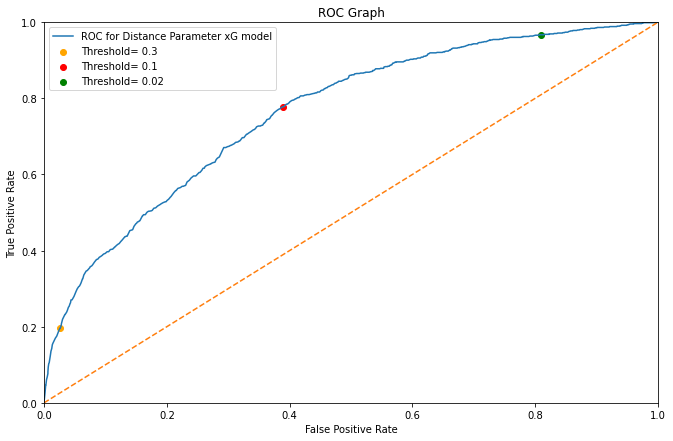

In [50]:
from sklearn.metrics import roc_curve
fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model')

plt.scatter(1-specificity_3,sensitivity_3,c='orange',label='Threshold= 0.3')
plt.scatter(1-specificity_10,sensitivity_10,c='red',label='Threshold= 0.1')
plt.scatter(1-specificity_02,sensitivity_02,c='green',label='Threshold= 0.02')
y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')


In [51]:
train_3 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3.drop('Goal',axis=1), 
                                                    train_3['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_xg = LogisticRegression()
lgm_xg.fit(x_train_3,y_train_3)
log_odds = lgm_3.coef_[0]
print(lgm_3.coef_, lgm_3.intercept_)


train_4 = df[['Goal','Distance','Angle Radians','header','Y']].copy()
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
                                                    train_4['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_4 = LogisticRegression()
lgm_4.fit(x_train_4,y_train_4)
log_odds = lgm_4.coef_[0]
print(lgm_4.coef_, lgm_4.intercept_)

[[-0.08812064  1.41583297 -0.00209564]] [-1.40900091]
[[-0.10774207  1.5946499  -1.01222477 -0.00277136]] [-0.9759078]


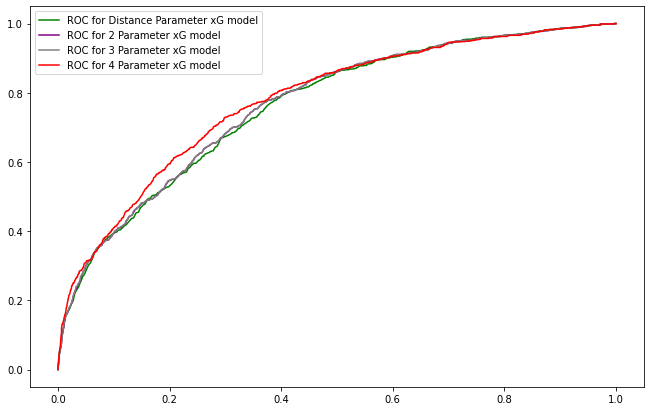

In [56]:
fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model',c='green')

y_score_2 = lgm_2.decision_function(x_test_2)
fpr2, tpr2, _  = roc_curve(y_test_2,y_score_2, pos_label=lgm_2.classes_[1])
plt.plot(fpr2,tpr2,label='ROC for 2 Parameter xG model',c='purple')

y_score_3 = lgm_3.decision_function(x_test_3)
fpr_3, tpr_3, _  = roc_curve(y_test_3,y_score_3, pos_label=lgm_3.classes_[1])
plt.plot(fpr_3,tpr_3,label='ROC for 3 Parameter xG model',c='grey')

y_score_4 = lgm_4.decision_function(x_test_4)
fpr_4, tpr_4, _  = roc_curve(y_test_4,y_score_4, pos_label=lgm_4.classes_[1])
plt.plot(fpr_4,tpr_4,label='ROC for 4 Parameter xG model',c='red')
plt.legend()

In [ ]:
predictions = lgm.predict(x_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
#print(lgm.coef_,lgm)
print(confusion_matrix(y_test, predictions))

In [ ]:
train = df[['Goal','Distance','Angle Radians','header']].copy()
x_train, x_test, y_train, y_test = train_test_split(train.drop('Goal',axis=1), 
                                                    train['Goal'], test_size=0.20, 
                                                    random_state=10)


lr_2 = LogisticRegression(random_state=0)
lr_2.fit(x_train,y_train)
log_odds = lgm.coef_[0]
print(lgm.coef_, lgm.intercept_)
print(pd.DataFrame(log_odds, 
             x_train.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))
predictions = lgm.predict(x_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))